## Train models on the enhanced data (with all new columns)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import configparser
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("../data_transformation/data_transfer"))

from utils import Connection, DataTransfer

config = configparser.ConfigParser()
config.read('../config.ini')

dt = DataTransfer(Connection(*(x[1] for x in config.items('database'))))

sql_query = """
SELECT *
FROM mart.admissions
"""

df = dt.fetch_data(sql_query)

In [3]:
df.head()

,subject_id,hadm_id,admittime,admit_daytime,admission_month,dischtime,deathtime,admission_type,admit_provider_id,admission_location,...,hematocrit_csf_max_value,hematocrit_csf_avg_value,hematocrit_csf_ref_range_lower,hematocrit_csf_ref_range_upper,hematocrit_csf_was_abnormal,hematocrit_csf_ratio_abnormal,hematocrit_csf_first_abnormal_charttime,hematocrit_csf_first_test_charttime,hematocrit_csf_last_test_charttime,hematocrit_csf_abnormal_hrs_until_discharge
0,10004113,29879900,2173-03-20 00:00:00,night,3.0,2173-03-22 14:35:00,NaT,SURGICAL SAME DAY ADMISSION,P64UQ5,PHYSICIAN REFERRAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
1,10007785,22943998,2156-05-16 01:36:00,night,5.0,2156-05-21 17:10:00,NaT,EW EMER.,P15TKT,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
2,10010888,20162667,2174-01-09 22:19:00,night,1.0,2174-01-27 16:00:00,NaT,EW EMER.,P26WQF,TRANSFER FROM HOSPITAL,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
3,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN
4,10013310,22098926,2153-06-10 11:55:00,morning,6.0,2153-07-21 18:00:00,NaT,OBSERVATION ADMIT,P95A45,INFORMATION NOT AVAILABLE,...,NaN,NaN,NaN,NaN,None,NaN,NaT,NaT,NaT,NaN


In [4]:
df = pd.get_dummies(df, columns=['admit_daytime'])

df = pd.get_dummies(df, columns=['marital_status'])

df = pd.get_dummies(df, columns=['race'])

df = pd.get_dummies(df, columns=['gender'])

df = pd.get_dummies(df, columns=['anchor_year_group'])

df['icd_code_numeric'] = df['icd_code'].replace({
    r'^I61.*': 'I61',   # Match codes starting with 'I61'
    r'^I63.*': 'I63',   # Match codes starting with 'I63'
    r'^G41.*': 'G41'    # Match codes starting with 'G41'
}, regex=True)

columns_to_drop = [column for column in df.columns if any(substring in column for substring in ['range', 'charttime'])]

In [5]:
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, KFold


cur_df = df.copy()
X = cur_df.drop('los', axis=1)
y = cur_df['los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


encoder = ce.BinaryEncoder(cols = [
    'first_careunit', 
    'last_careunit', 
    'admission_type',
    'admission_location',
    'discharge_location',
    'insurance',
    'language',
    'icd_code_numeric'
] , return_df = True)

encoder.fit(X_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [6]:
X_train.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',

    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

X_test.drop(columns=[
    'dod',
    'icd_code',
    'icd_version',
    'stay_id',
    'admit_provider_id',
    'subject_id',
    'hadm_id',
    
    #timestamp columns
    'intime',
    'outtime',
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'edouttime',
    *columns_to_drop
], inplace=True, axis=1)

In [7]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [8]:
def fillna_tests(test_name: str, df: pd.DataFrame):
    df[f'{test_name}_min_value'].fillna(-1, inplace=True)
    df[f'{test_name}_max_value'].fillna(-1, inplace=True)
    df[f'{test_name}_avg_value'].fillna(-1, inplace=True)
    df[f'{test_name}_was_abnormal'].fillna(False, inplace=True)
    df[f'{test_name}_ratio_abnormal'].fillna(0, inplace=True)
    df[f'{test_name}_abnormal_hrs_until_discharge'].fillna(-1, inplace=True)

In [9]:
tests = [
    'sodium',
    'sodium_urine',
    'sodium_whole_blood',
    'potassium',
    'potassium_whole_blood',
    'calcium_total',
    'free_calcium',
    'magnesium',
    'glucose',
    'glucose_ascites',
    'glucose_body_fluid', 
    'glucose_csf',
    'lactate',
    'lactate_dehydrogenase_csf',
    'lactate_dehydrogenase_ld',
    'ph',
    'po2',
    'bicarbonate',
    'bicarbonate_urine',
    'calculated_bicarbonate_whole_blood',
    'inr_pt',
    'pt',
    'ptt',
    'crp',
    'white_blood_cells',
    'ammonia',
    'albumin',
    'albumin_creatine_urine',
    'creatinine',
    'creatinine_clearance',
    'creatinine_serum',
    'urea_nitrogen',
    'alt',
    'ast',
    'bilirubin',
    'bilirubin_direct',
    'bilirubin_indirect',
    'bilirubin_total',
    'ratio_hemoglobin_a1c',
    'hemoglobin',
    'hematocrit',
    'hematocrit_csf'
]

In [10]:
for test in tests:
    fillna_tests(test, X_train)
    fillna_tests(test, X_test)

In [11]:
print(X_train.columns[X_train.isnull().sum() > 0])

Index([], dtype='object')


In [12]:
print(X_test.columns[X_test.isnull().sum() > 0])

Index([], dtype='object')


<Axes: >

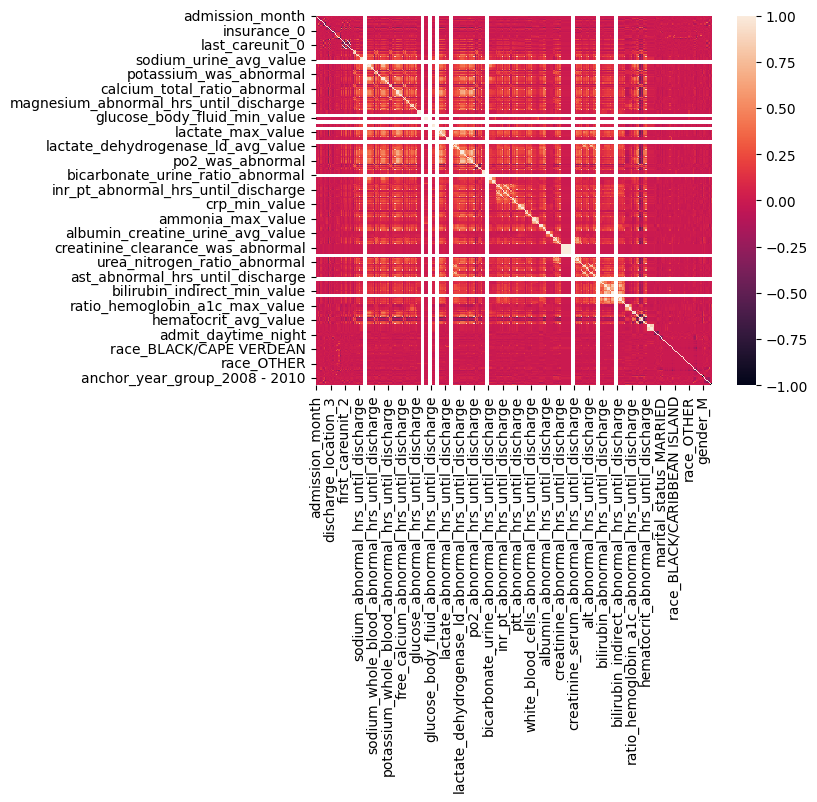

In [13]:
import seaborn as sns
%matplotlib inline

corr = X_train.corr()

sns.heatmap(corr)

In [14]:
X_train.corrwith(y_train).sort_values(ascending=False).head(21)

po2_abnormal_hrs_until_discharge                      0.465855
glucose_abnormal_hrs_until_discharge                  0.463430
white_blood_cells_abnormal_hrs_until_discharge        0.458789
hemoglobin_abnormal_hrs_until_discharge               0.456083
ph_abnormal_hrs_until_discharge                       0.452716
hematocrit_abnormal_hrs_until_discharge               0.450645
urea_nitrogen_abnormal_hrs_until_discharge            0.450566
sodium_abnormal_hrs_until_discharge                   0.450512
inr_pt_abnormal_hrs_until_discharge                   0.444758
pt_abnormal_hrs_until_discharge                       0.442618
calcium_total_abnormal_hrs_until_discharge            0.441461
bicarbonate_abnormal_hrs_until_discharge              0.438224
ptt_abnormal_hrs_until_discharge                      0.409604
potassium_abnormal_hrs_until_discharge                0.392971
free_calcium_abnormal_hrs_until_discharge             0.392717
potassium_whole_blood_abnormal_hrs_until_discharge    0

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from ml_utils import learn_models

In [16]:
X_train.head()

,admission_month,admission_type_0,admission_type_1,admission_type_2,admission_type_3,admission_location_0,admission_location_1,admission_location_2,admission_location_3,discharge_location_0,discharge_location_1,discharge_location_2,discharge_location_3,insurance_0,insurance_1,insurance_2,language_0,language_1,language_2,language_3,language_4,hospital_expire_flag,first_careunit_0,first_careunit_1,first_careunit_2,first_careunit_3,last_careunit_0,last_careunit_1,last_careunit_2,last_careunit_3,anchor_year,sodium_min_value,sodium_max_value,sodium_avg_value,sodium_was_abnormal,sodium_ratio_abnormal,sodium_abnormal_hrs_until_discharge,sodium_urine_min_value,sodium_urine_max_value,sodium_urine_avg_value,sodium_urine_was_abnormal,sodium_urine_ratio_abnormal,sodium_urine_abnormal_hrs_until_discharge,sodium_whole_blood_min_value,sodium_whole_blood_max_value,sodium_whole_blood_avg_value,sodium_whole_blood_was_abnormal,sodium_whole_blood_ratio_abnormal,sodium_whole_blood_abnormal_hrs_until_discharge,potassium_min_value,potassium_max_value,potassium_avg_value,potassium_was_abnormal,potassium_ratio_abnormal,potassium_abnormal_hrs_until_discharge,potassium_whole_blood_min_value,potassium_whole_blood_max_value,potassium_whole_blood_avg_value,potassium_whole_blood_was_abnormal,potassium_whole_blood_ratio_abnormal,potassium_whole_blood_abnormal_hrs_until_discharge,calcium_total_min_value,calcium_total_max_value,calcium_total_avg_value,calcium_total_was_abnormal,calcium_total_ratio_abnormal,calcium_total_abnormal_hrs_until_discharge,free_calcium_min_value,free_calcium_max_value,free_calcium_avg_value,free_calcium_was_abnormal,free_calcium_ratio_abnormal,free_calcium_abnormal_hrs_until_discharge,magnesium_min_value,magnesium_max_value,magnesium_avg_value,magnesium_was_abnormal,magnesium_ratio_abnormal,magnesium_abnormal_hrs_until_discharge,glucose_min_value,glucose_max_value,glucose_avg_value,glucose_was_abnormal,glucose_ratio_abnormal,glucose_abnormal_hrs_until_discharge,glucose_ascites_min_value,glucose_ascites_max_value,glucose_ascites_avg_value,glucose_ascites_was_abnormal,glucose_ascites_ratio_abnormal,glucose_ascites_abnormal_hrs_until_discharge,glucose_body_fluid_min_value,glucose_body_fluid_max_value,glucose_body_fluid_avg_value,glucose_body_fluid_was_abnormal,glucose_body_fluid_ratio_abnormal,glucose_body_fluid_abnormal_hrs_until_discharge,glucose_csf_min_value,glucose_csf_max_value,glucose_csf_avg_value,glucose_csf_was_abnormal,glucose_csf_ratio_abnormal,glucose_csf_abnormal_hrs_until_discharge,lactate_min_value,lactate_max_value,lactate_avg_value,lactate_was_abnormal,lactate_ratio_abnormal,lactate_abnormal_hrs_until_discharge,lactate_dehydrogenase_csf_min_value,lactate_dehydrogenase_csf_max_value,lactate_dehydrogenase_csf_avg_value,lactate_dehydrogenase_csf_was_abnormal,lactate_dehydrogenase_csf_ratio_abnormal,lactate_dehydrogenase_csf_abnormal_hrs_until_discharge,lactate_dehydrogenase_ld_min_value,lactate_dehydrogenase_ld_max_value,lactate_dehydrogenase_ld_avg_value,lactate_dehydrogenase_ld_was_abnormal,lactate_dehydrogenase_ld_ratio_abnormal,lactate_dehydrogenase_ld_abnormal_hrs_until_discharge,ph_min_value,ph_max_value,ph_avg_value,ph_was_abnormal,ph_ratio_abnormal,ph_abnormal_hrs_until_discharge,po2_min_value,po2_max_value,po2_avg_value,po2_was_abnormal,po2_ratio_abnormal,po2_abnormal_hrs_until_discharge,bicarbonate_min_value,bicarbonate_max_value,bicarbonate_avg_value,bicarbonate_was_abnormal,bicarbonate_ratio_abnormal,bicarbonate_abnormal_hrs_until_discharge,bicarbonate_urine_min_value,bicarbonate_urine_max_value,bicarbonate_urine_avg_value,bicarbonate_urine_was_abnormal,bicarbonate_urine_ratio_abnormal,bicarbonate_urine_abnormal_hrs_until_discharge,calculated_bicarbonate_whole_blood_min_value,calculated_bicarbonate_whole_blood_max_value,calculated_bicarbonate_whole_blood_avg_value,calculated_bicarbonate_whole_blood_was_abnormal,calculated_bicarbonate_whole_blood_ratio_abnormal,calculated_bicarbonate_whole_blood_abnormal_hrs_unt

In [17]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
# from catboost import CatBoostRegressor

initial_results = learn_models(
    models={
        'Linear Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(
            n_estimators=100, 
            max_depth=5, 
            random_state=42, 
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100, 
            max_depth=5, 
            learning_rate=0.1, 
            objective='reg:squarederror', 
            random_state=42
        ),
        # 'CatBoost': CatBoostRegressor(
        #     iterations=100, 
        #     depth=5, 
        #     learning_rate=0.1, 
        #     loss_function='RMSE', 
        #     random_seed=42,
        #     verbose=False
        # )
    },
    dfs=[X_train, X_test, y_train, y_test],
    folder='initial_train'
)

Training Linear Regression...
Linear Regression: RMSE = 6.934540777047273, MAE = 3.8734374564653815, R² = 0.2656018049263298
Training Random Forest...
Random Forest: RMSE = 6.389190918341178, MAE = 3.6560222902032065, R² = 0.37656968051131967
Training XGBoost...
XGBoost: RMSE = 6.299856114572757, MAE = 3.126135727181855, R² = 0.3938816262892316


## Results of training

In [18]:
initial_results

,model,MSE,MAE,RMSE,R2
0,Linear Regression,48.087856,3.873437,6.934541,0.265602
1,Random Forest,40.821761,3.656022,6.389191,0.376570
2,XGBoost,39.688187,3.126136,6.299856,0.393882


In [19]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [20]:
from ml_utils import FeatureExtractor

fe = FeatureExtractor(X_train.columns.tolist())

#### Linear Regression

In [21]:
fe.extract_feature_importance('initial_train', 'Linear Regression').head(20)

race_ASIAN - KOREAN                            9.330878
ratio_hemoglobin_a1c_ratio_abnormal            6.581238
ratio_hemoglobin_a1c_was_abnormal              5.906469
crp_was_abnormal                               5.781150
free_calcium_min_value                         5.506691
crp_ratio_abnormal                             5.227768
bilirubin_direct_was_abnormal                  4.413205
bilirubin_indirect_avg_value                   4.378693
free_calcium_max_value                         4.251834
bilirubin_direct_ratio_abnormal                3.551297
bilirubin_indirect_max_value                   3.527384
race_ASIAN - ASIAN INDIAN                      3.495278
po2_ratio_abnormal                             2.971116
race_AMERICAN INDIAN/ALASKA NATIVE             2.856607
po2_was_abnormal                               2.819367
race_HISPANIC/LATINO - CENTRAL AMERICAN        2.812051
ammonia_ratio_abnormal                         2.475822
bicarbonate_urine_max_value                    2

#### Random Forest Regression

In [22]:
fe.extract_feature_importance('initial_train', 'Random Forest').head(20)

po2_abnormal_hrs_until_discharge                     0.424096
glucose_abnormal_hrs_until_discharge                 0.093606
potassium_whole_blood_abnormal_hrs_until_discharge   0.043648
albumin_abnormal_hrs_until_discharge                 0.025629
first_careunit_3                                     0.021330
sodium_abnormal_hrs_until_discharge                  0.020665
sodium_avg_value                                     0.018154
free_calcium_abnormal_hrs_until_discharge            0.016371
last_careunit_3                                      0.015823
creatinine_avg_value                                 0.015479
sodium_max_value                                     0.015067
bicarbonate_max_value                                0.014156
magnesium_avg_value                                  0.013243
sodium_whole_blood_abnormal_hrs_until_discharge      0.012221
free_calcium_max_value                               0.012135
po2_ratio_abnormal                                   0.010048
ph_abnor

#### Gradient Boosting Regression

In [ ]:
fe.extract_feature_importance('initial_train', 'XGBoost').head(20)

## Train after feature selection

Now I'll take 20 most important features for each algorithm and will compare the results to the original ones

In [ ]:
lr_X_train, lr_X_test = fe.select_k_most_relevant_features_from_df(20, 'initial_train', 'Linear Regression', X_train, X_test)
rfr_X_train, rfr_X_test = fe.select_k_most_relevant_features_from_df(20, 'initial_train', 'Random Forest', X_train, X_test)
gbr_X_train, gbr_X_test = fe.select_k_most_relevant_features_from_df(20, 'initial_train', 'XGBoost', X_train, X_test)

In [29]:
top_20_features_results

,model,MSE,MAE,RMSE,R2
0,Linear Regression,59.678929,4.552630,7.725214,0.088583
1,Random Forest,41.072135,3.667294,6.408755,0.372746
2,XGBoost,43.324399,3.453222,6.582127,0.338349


In [30]:
initial_results

,model,MSE,MAE,RMSE,R2
0,Linear Regression,48.087856,3.873437,6.934541,0.265602
1,Random Forest,40.821761,3.656022,6.389191,0.376570
2,XGBoost,39.688187,3.126136,6.299856,0.393882
